In [1]:
# Importación de librerías 
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from sklearn.metrics import r2_score
from sklearn.ensemble import RandomForestRegressor
# Seteo para que no se muestre notación científica
np.set_printoptions(suppress=True)
# Saco los warnings
import warnings
warnings.filterwarnings("ignore")

In [2]:
# Levanto el dataset
url = 'https://raw.githubusercontent.com/xlisouski/DataCoder/main/train.csv'
df = pd.read_csv(url, sep = ',')
df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


# Feature Engineering 
Es un proceso fundamental en la construcción de modelos de aprendizaje automático. Consiste en seleccionar, transformar o crear nuevas características a partir de las variables existentes en tus datos con el objetivo de mejorar el rendimiento del modelo. 
<br></br>
**Algunas ténicas:** 
1. Creación de variables dummy (binarias)
2. Estandarización 
3. Transformaciones matemáticas (logaritmos, trans. exponenciales)
4. Discretización (de contínua a categórica)
5. Combinaciones algebraicas 
6. Label o target encoding 
7. Variables con factor tiempo (extraer día, mes, año, momento del día, tiempo transcurrido)
8. Text mining 
9. PCA
10. Clustering

# EDA 
Previo a la construcción de nuevos features es extremadamente importante tener conocimiento sobre las relaciones existentes, posibles patrones a capturar. 
<br>
**Qué nos dicen los datos?** 
Evaluemos algunas variables que hasta el momento no hemos estudiado. 
<br>
**Variable target:** La transformamos en logaritmo para suavizar los outliers y detectar patrones de comportamiento


In [3]:
df['SalePrice_log'] = np.log(df['SalePrice'])
df['SalePrice_log'].describe()

count    1460.000000
mean       12.024051
std         0.399452
min        10.460242
25%        11.775097
50%        12.001505
75%        12.273731
max        13.534473
Name: SalePrice_log, dtype: float64

### MSSubClass: 
**Significado:** Identifies the type of dwelling involved in the sale.	
<br>
**Valores Posibles:**

Variable  | Descripcion
-------------------|------------------
20|1-STORY 1946 & NEWER ALL STYLES
30|1-STORY 1945 & OLDER
40|1-STORY W/FINISHED ATTIC ALL AGES
45|1-1/2 STORY - UNFINISHED ALL AGES
50|1-1/2 STORY FINISHED ALL AGES
60|2-STORY 1946 & NEWER
70|2-STORY 1945 & OLDER
75|2-1/2 STORY ALL AGES
80|SPLIT OR MULTI-LEVEL
85|SPLIT FOYER
90|DUPLEX - ALL STYLES AND AGES
120|1-STORY PUD (Planned Unit Development) - 1946 & NEWER
150|1-1/2 STORY PUD - ALL AGES
160|2-STORY PUD - 1946 & NEWER
180|PUD - MULTILEVEL - INCL SPLIT LEV/FOYER
190|2 FAMILY CONVERSION - ALL STYLES AND AGES

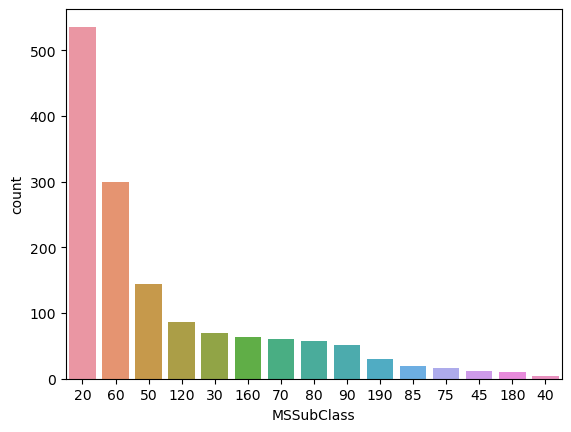

In [4]:
# Primer chequeo: volumen por categoria?
plt.figure()
order = df['MSSubClass'].value_counts().index
sns.countplot(data = df,
              x = "MSSubClass",
              order=order)
plt.show()

#### Puntos a resolver: 
Desde la categoría 120 en adelante hay menos de 100 casas por grupo. Posiblemente sea un volúmen demasiado pequeño como para tratarlos por separado. Juntemos las categorías en función a la descripción que más se parecen.
<br></br>

**Clasificación Propuesta:**

1. Casas de un piso: 20, 30, 40, 120
2. Casas de un piso y medio: 45, 50, 150
3. Casas de 2 pisos o 2 y medio: 60, 70, 160, 75
4. Otros: 80, 85, 90, 180, 190 

In [5]:
# Función clasificadora 
def clasifica_MSSubClass(MSSubClass):
    if (MSSubClass in (20, 30, 40, 120)):
        return "1"
    elif (MSSubClass in (45, 50, 150)):
        return "2"
    elif (MSSubClass in (60, 70, 160, 75)):
        return "3"
    elif (MSSubClass in (80, 85, 90, 180, 190 )):
        return "4"    
    else:
        return "Sin_Dato"
    
# Aplico el clasificador
df['MSSubClass_Bin'] =  df.apply(lambda row: clasifica_MSSubClass(row['MSSubClass']), 
                                 axis = 1)

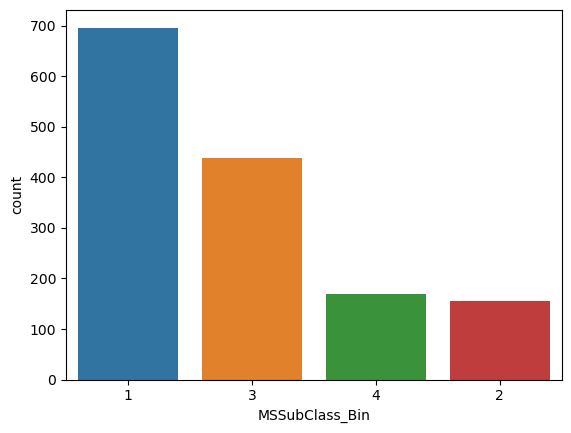

In [6]:
# Cómo quedamos de volumen?
plt.figure()
order = df['MSSubClass_Bin'].value_counts().index
sns.countplot(data = df,
              x = "MSSubClass_Bin",
              order=order)
plt.show()

Text(0.5, 1.0, 'Relación entre tipo de vivienda y su precio')

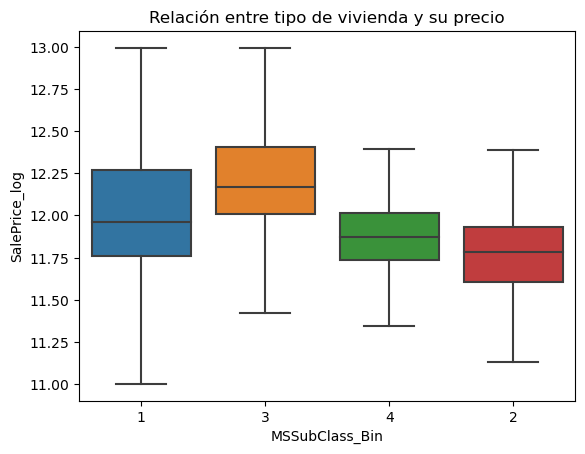

In [7]:
# Evaluemos la relación con el target
plt.figure()
sns.boxplot(data = df,
            x = 'MSSubClass_Bin',
            y = 'SalePrice_log', 
            showfliers = False,
            order=order)
plt.title('Relación entre tipo de vivienda y su precio')

### Conclusión: 
Efectivamente hay diferencia entre la cantidad de pisos que tienen las casas, fundamentalmente en las categorías 1 (un piso) vs 3 (dos o más pidos). Con esta información, vamos a construir dos variables binarias. 

In [8]:
# Construccion binarias
df['MSSubClass_Es1Piso'] = np.where(df['MSSubClass'].isin([20, 30, 40, 120]),1,0)
df['MSSubClass_Es2Pisos'] = np.where(df['MSSubClass'].isin([60, 70, 160, 75]),1,0)

### MSZoning: 
**Significado:** Identifies the general zoning classification of the sale.	
<br>
**Valores Posibles:**

Variable  | Descripcion
-------------------|------------------
A|	Agriculture
C|	Commercial
FV|	Floating Village Residential
I|	Industrial
RH|	Residential High Density
RL|	Residential Low Density
RP|	Residential Low Density Park 
RM|	Residential Medium Density

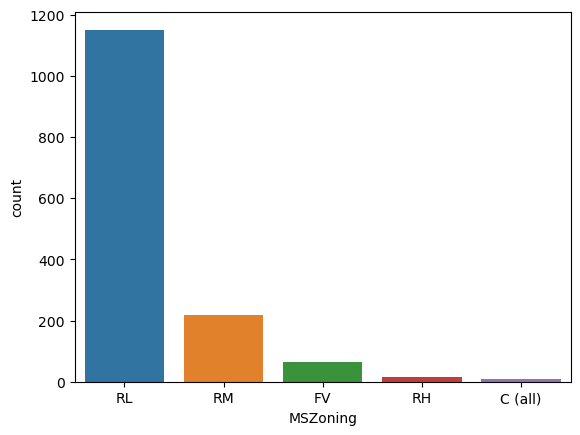

In [9]:
# Primer chequeo: volumen por categoria?
plt.figure()
order = df['MSZoning'].value_counts().index
sns.countplot(data = df,
              x = "MSZoning",
              order=order)
plt.show()

#### Puntos a resolver: 
Desde la categoría FV en adelante hay menos de 100 casas por grupo. Posiblemente sea un volúmen demasiado pequeño como para tratarlos por separado. 

Text(0.5, 1.0, 'Relación entre zona de la vivienda y su precio')

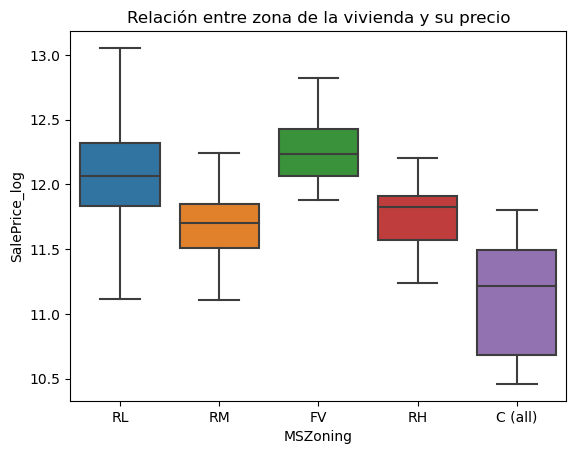

In [10]:
# Evaluemos la relación con el target
plt.figure()
sns.boxplot(data = df,
            x = 'MSZoning',
            y = 'SalePrice_log', 
            showfliers = False,
            order=order)
plt.title('Relación entre zona de la vivienda y su precio')

### Conclusión: 
Efectivamente hay diferencia según la zona de la vivienda. Construyamos 2 binarias para identificar a las casas de zonas más caras (RL y FV). 

In [11]:
# Construccion binarias
df['MSZoning_RL'] = np.where(df['MSZoning'].isin(['RL']),1,0)
df['MSZoning_FV'] = np.where(df['MSZoning'].isin(['FV']),1,0)

### Street: 
**Significado:** Type of road access to property.
<br>
**Valores Posibles:**

Variable  | Descripcion
-------------------|------------------
Grvl|	Gravel	
Pave|	Paved

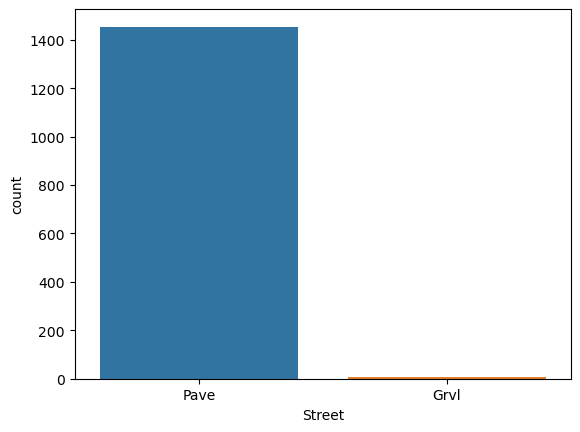

In [12]:
# Primer chequeo: volumen por categoria?
plt.figure()
order = df['Street'].value_counts().index
sns.countplot(data = df,
              x = "Street",
              order=order)
plt.show()

### Conclusión: 
Prácticamente no hay casas con acceso Grvl. Por ello, vamos a dejar fuera a esta variable para el modelo. 

### Alley: 
**Significado:** Type of alley access to property.
<br>
**Valores Posibles:**

Variable  | Descripcion
-------------------|------------------
Grvl|	Gravel
Pave|	Paved
NA| 	No alley access

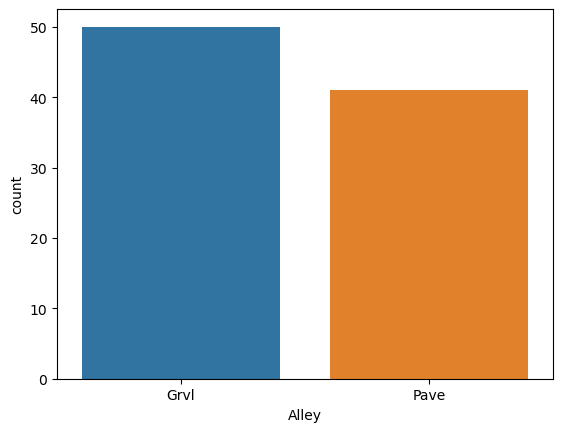

In [13]:
# Primer chequeo: volumen por categoria?
plt.figure()
order = df['Alley'].value_counts().index
sns.countplot(data = df,
              x = "Alley",
              order=order)
plt.show()

Text(0.5, 1.0, 'Relación entre Alley y su precio')

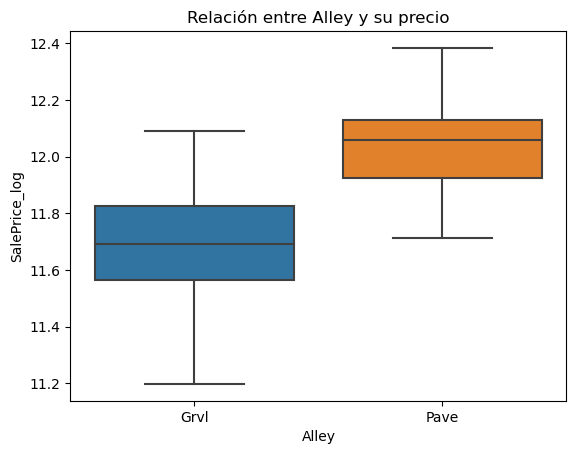

In [14]:
# Evaluemos la relación con el target
plt.figure()
sns.boxplot(data = df,
            x = 'Alley',
            y = 'SalePrice_log', 
            showfliers = False,
            order=order)
plt.title('Relación entre Alley y su precio')

### Conclusión: 
Claramente las casas con acceso pavimentado parecieran ser más caras. Vamos a crear una variable binaria para detectar si la casa tiene acceso pavimentado. 

In [15]:
# Construccion binarias
df['Alley_Pave'] = np.where(df['Alley'].isin(['Pave']),1,0)

### MasVnrType: 
**Significado:** Masonry veneer type.
<br>
**Valores Posibles:**

Variable  | Descripcion
-------------------|------------------
BrkCmn|	Brick Common
BrkFace|	Brick Face
CBlock|	Cinder Block
None|	None
Stone|	Stone

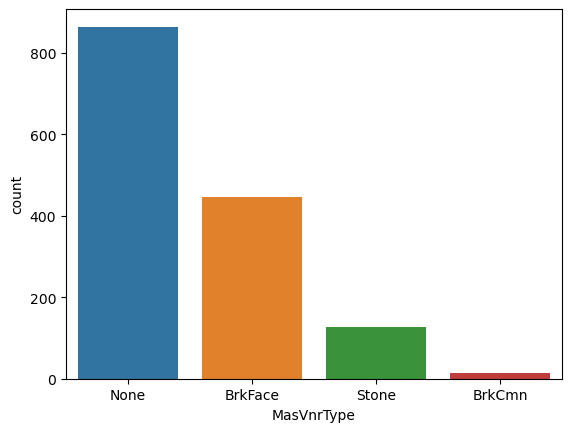

In [16]:
# Primer chequeo: volumen por categoria?
plt.figure()
order = df['MasVnrType'].value_counts().index
sns.countplot(data = df,
              x = "MasVnrType",
              order=order)
plt.show()

Text(0.5, 1.0, 'Relación entre tipo de revestimiento y su precio')

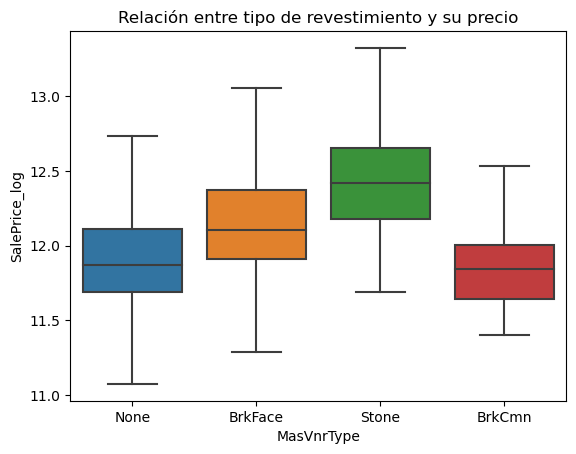

In [17]:
# Evaluemos la relación con el target
plt.figure()
sns.boxplot(data = df,
            x = 'MasVnrType',
            y = 'SalePrice_log', 
            showfliers = False,
            order=order)
plt.title('Relación entre tipo de revestimiento y su precio')

### Conclusión: 
Claramente las casas con revestimiento de piedra son más caras. Por otro lado, le siguen las casa de ladrillos. Generemos entonces dos variables binarias con esta información. 

In [18]:
# Construccion binarias
df['MasVnrType_Stone'] = np.where(df['MasVnrType'].isin(['Stone']),1,0)
df['MasVnrType_BrkFace'] = np.where(df['MasVnrType'].isin(['BrkFace']),1,0)

# Variables con factor tiempo
Generalmente, las variables que tienen asociada algún tipo de fecha no aportan demasiado valor agregado por si misma. Lo que realmente genera una diferencia es lo que construimos a partir de ellas. 
<br> <br/>
En este caso, tenemos disponible la siguiente información respecto al tiempo: 
* YrSold: Año de venta 
* YearBuilt: Fecha de origen de la construcción de la vivienda 
* YearRemodAdd: Fecha en que se remodeló la vivienda 
* GarageYrBlt: Año en que se construyó el garage 

In [19]:
# Construcción de las variables : 
df['Antig_Viv'] = df['YrSold'] - df['YearBuilt']
df['Antig_Rem'] = np.where( df['YearRemodAdd'] > df['YrSold'],
                            df['YrSold'] - df['YearBuilt'],
                            df['YrSold'] - df['YearRemodAdd'])
df['Antig_Garage'] = np.where((df['GarageYrBlt'] > df['YrSold']) | (df['GarageYrBlt'].isnull()),
                            999,
                            df['YrSold'] - df['GarageYrBlt'])

In [20]:
df['Antig_Viv'].describe()

count    1460.000000
mean       36.547945
std        30.250152
min         0.000000
25%         8.000000
50%        35.000000
75%        54.000000
max       136.000000
Name: Antig_Viv, dtype: float64

In [21]:
df['Antig_Rem'].describe()

count    1460.000000
mean       22.950685
std        20.639875
min         0.000000
25%         4.000000
50%        14.000000
75%        41.000000
max        60.000000
Name: Antig_Rem, dtype: float64

In [22]:
df['Antig_Garage'].describe()

count    1460.000000
mean       83.104110
std       223.348822
min         0.000000
25%         7.000000
50%        30.000000
75%        50.000000
max       999.000000
Name: Antig_Garage, dtype: float64

### Problemas: 
La variable de antiguedad del garage sólo es válida para las casas con garage. Por ello, no es lo mejor utilizarla así suelta, hay que darle un tratamiento. 
<br>
En este caso vamos a categorizarla. Para seleccionar los cortes, vamos a utilizar los resultados de un árbol de decisión. 

Text(0.5, 1.0, 'Relación entre Precio de Venta y Antiguedad del Garage')

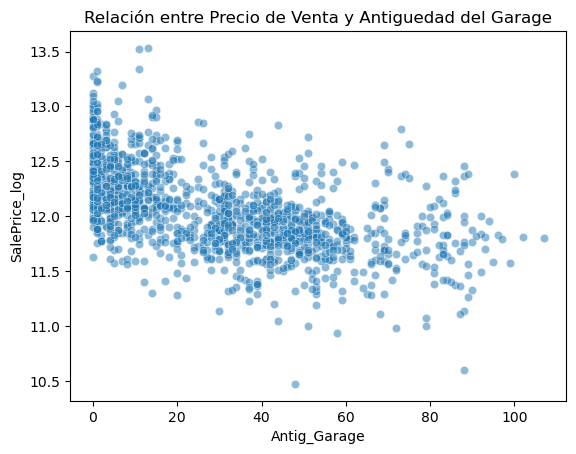

In [23]:
# Cómo es la relación con el target?
sns.scatterplot(data = df.loc[df['Antig_Garage'] < 999,],
                x = 'Antig_Garage',
                y = 'SalePrice_log',
               alpha = 0.5)
plt.title('Relación entre Precio de Venta y Antiguedad del Garage')

In [24]:
# Genero el arbol
from sklearn.tree import DecisionTreeRegressor, plot_tree

df_garage = df.loc[df['Antig_Garage'] < 999,]

X = df_garage['Antig_Garage'].values.reshape(-1, 1)
y = df_garage['SalePrice_log'].values

regressor = DecisionTreeRegressor(max_depth = 3,
                                  min_samples_split = 300,
                                  min_samples_leaf = 200,
                                  random_state = 123)
regressor.fit(X, y)

y_pred = regressor.predict(X)
y_pred


array([12.22502513, 11.94715939, 12.22502513, ..., 11.78397955,
       11.78397955, 11.86673138])

[Text(0.5, 0.875, 'node #0\nAntig_Garage <= 19.5\nsamples = 100.0%\nvalue = 12.055'),
 Text(0.25, 0.625, 'node #1\nAntig_Garage <= 3.5\nsamples = 44.1%\nvalue = 12.293'),
 Text(0.125, 0.375, 'node #2\nsamples = 17.4%\nvalue = 12.397'),
 Text(0.375, 0.375, 'node #3\nsamples = 26.7%\nvalue = 12.225'),
 Text(0.75, 0.625, 'node #4\nAntig_Garage <= 51.5\nsamples = 55.9%\nvalue = 11.868'),
 Text(0.625, 0.375, 'node #5\nAntig_Garage <= 38.5\nsamples = 37.4%\nvalue = 11.909'),
 Text(0.5, 0.125, 'node #6\nsamples = 19.8%\nvalue = 11.947'),
 Text(0.75, 0.125, 'node #7\nsamples = 17.6%\nvalue = 11.867'),
 Text(0.875, 0.375, 'node #8\nsamples = 18.5%\nvalue = 11.784')]

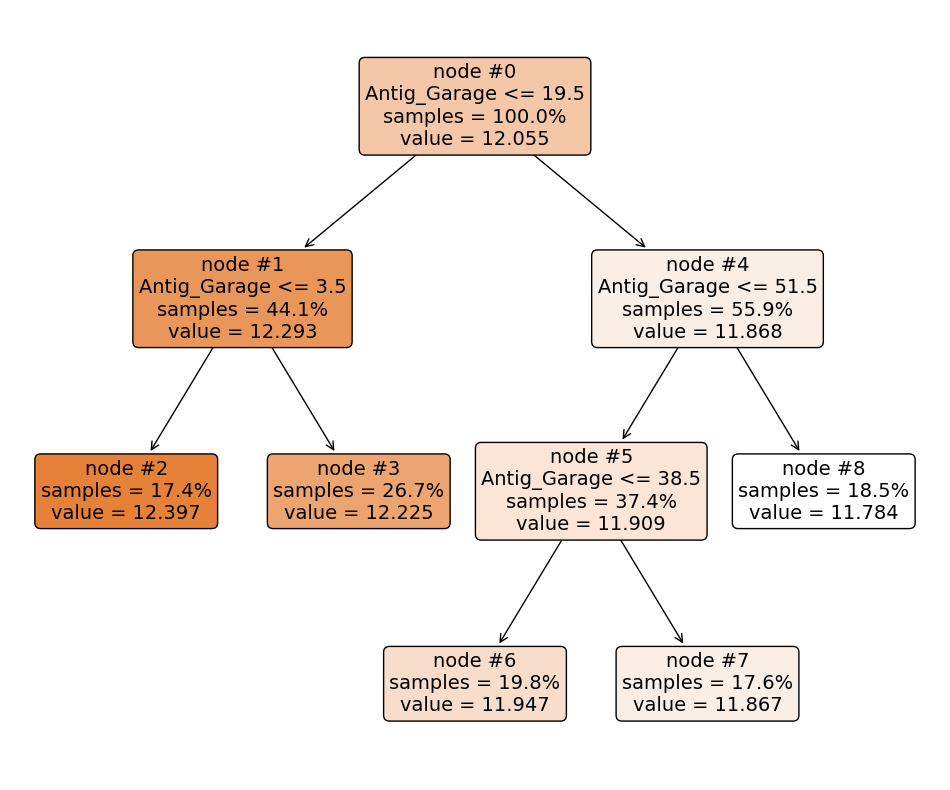

In [25]:
# Visualmente
plt.figure(figsize=(12, 10))
plot_tree(regressor, 
          filled = True, 
          rounded = True, 
          feature_names = ['Antig_Garage'], 
          impurity = False,
          proportion = True,
          node_ids = True)

In [26]:
# Genero las clasificaciones
# Función clasificadora 
def clasifica_Antig_Garage(Antig_Garage):
    if (Antig_Garage == 999):
        return "0_Sin_Garage"
    elif (Antig_Garage < 3):
        return "1_Gar_MuyNvo"
    elif (Antig_Garage < 20):
        return "2_Gar_Nvo"
    elif (Antig_Garage < 40):
        return "3_Gar_SemiNvo"    
    elif (Antig_Garage < 50):
        return "4_Gar_Antiguo"
    elif (Antig_Garage >= 50):
        return "5_Gar_MuyAntiguo"
    else:
        return "Sin_Dato"
    
# Aplico el clasificador
df['Antig_Garage_Bin'] =  df.apply(lambda row: clasifica_Antig_Garage(row['Antig_Garage']), 
                                 axis = 1)

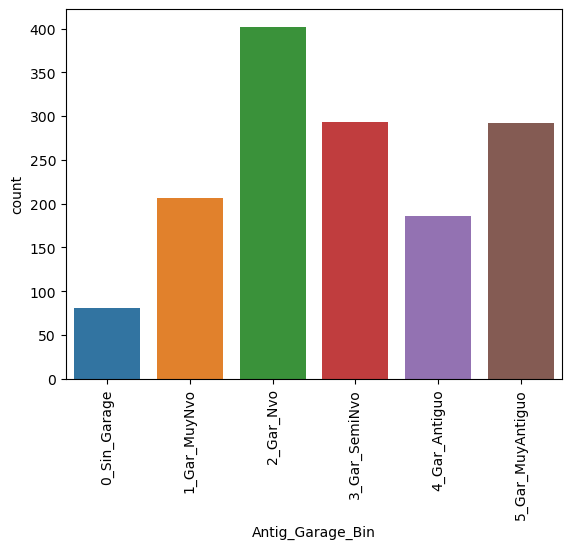

In [27]:
# Primer chequeo: volumen por categoria?
plt.figure()
order = df['Antig_Garage_Bin'].value_counts().sort_index().index
sns.countplot(data = df,
              x = "Antig_Garage_Bin",
              order = order)
plt.xticks(rotation=90) 
plt.show()

Text(0.5, 1.0, 'Relación entre Antiguedad del Garage y su precio')

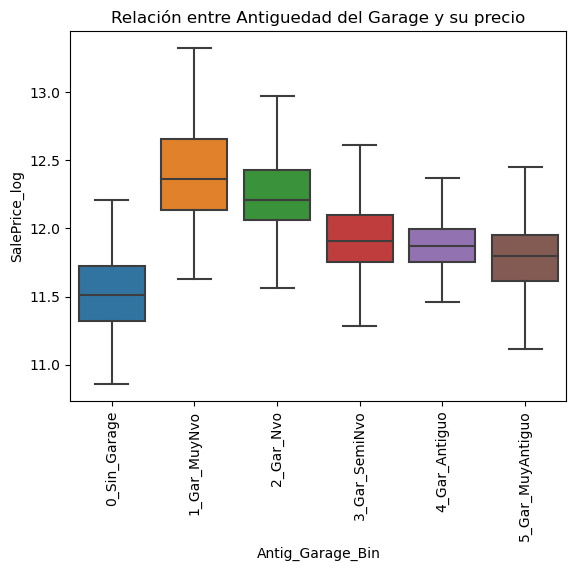

In [28]:
# Evaluemos la relación con el target
plt.figure()
sns.boxplot(data = df,
            x = 'Antig_Garage_Bin',
            y = 'SalePrice_log', 
            showfliers = False,
            order=order)
plt.xticks(rotation=90) 
plt.title('Relación entre Antiguedad del Garage y su precio')

### Conclusión: 
Las casas sin garage tienen el menor precio, mientras que cuanto más nuevo es el garage, más alto es el precio. Construyamos algunas binarias. 

In [29]:
# Construccion binarias
df['Garage_MuyNvo'] = np.where(df['Antig_Garage'] < 3,1,0)
df['Garage_Nvo'] = np.where((df['Antig_Garage'] >= 3) & (df['Antig_Garage'] < 20),1,0)
df['Garage_SemiNvo'] = np.where((df['Antig_Garage'] >= 29) & (df['Antig_Garage'] < 40),1,0)

# Nombres en features
No es recomendable que los nombres de features empiecen en números o en signos extraños, ya que pueden traer problemas en el uso de ciertas funciones. 
Cambiemos el nombre de algunas variables que pueden generar problemas.

In [30]:
# Filtrar las columnas cuyo primer carácter es un número
columnas_con_numero = [col for col in df.columns if col[0].isdigit()]

# Imprimir las columnas con números en el primer carácter
print(columnas_con_numero)

['1stFlrSF', '2ndFlrSF', '3SsnPorch']


In [31]:
# Vamos a renombrarlas 
df = df.rename(columns={'1stFlrSF': 'V_1stFlrSF'})
df = df.rename(columns={'2ndFlrSF': 'V_2ndFlrSF'})
df = df.rename(columns={'3SsnPorch': 'V_3SsnPorch'})

# TRAIN Y TEST

In [32]:
df.columns

Index(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', 'V_1stFlrSF', 'V_2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual',
       'GarageCond', 'PavedD

In [33]:
# Separamos en train y test
from sklearn.model_selection import train_test_split

# Variables a procesar
features = ['GrLivArea','GarageArea','GarageCars','OverallQual','LotFrontage','LotArea',
            'OverallCond','V_1stFlrSF','V_2ndFlrSF','V_3SsnPorch','BsmtFullBath',
            'BsmtHalfBath','FullBath', 'MSSubClass_Es1Piso', 'MSSubClass_Es2Pisos',
            'MSZoning_RL', 'MSZoning_FV', 'Alley_Pave', 'MasVnrType_Stone', 'MasVnrType_BrkFace', 
            'Antig_Viv', 'Antig_Rem', 'Garage_MuyNvo', 'Garage_Nvo', 'Garage_SemiNvo',
            'SalePrice']

df_limpia = df.dropna(subset= features)
df_train,df_test = train_test_split(df_limpia,
                                    test_size = 0.3, #Porcentaje de muestra test 
                                    random_state = 43) #Semilla
df_train = df_train.reset_index()
df_test = df_test.reset_index()

# Estandarizando los datos

In [34]:
# Normalizamos los datos
from sklearn.preprocessing import StandardScaler

# Selecciono las variables no binarias
features_no_bin = ['GrLivArea','GarageArea','GarageCars','OverallQual','LotFrontage','LotArea',
            'OverallCond','V_1stFlrSF','V_2ndFlrSF','V_3SsnPorch','BsmtFullBath',
            'BsmtHalfBath','FullBath','Antig_Viv', 'Antig_Rem',
            'SalePrice']

features_bin = [ 'MSSubClass_Es1Piso', 'MSSubClass_Es2Pisos',
            'MSZoning_RL', 'MSZoning_FV', 'Alley_Pave', 'MasVnrType_Stone', 'MasVnrType_BrkFace', 
             'Garage_MuyNvo', 'Garage_Nvo', 'Garage_SemiNvo',]

X_train = df_train[features_no_bin].values
X_test = df_test[features_no_bin].values

# Defino escalador
sc = StandardScaler()
# Genero parámetros con train
X_train = sc.fit_transform(X_train)
# Le aplico el escalador a test
X_test = sc.transform(X_test)

# Genero df
df_train_scaled = pd.DataFrame(data = X_train)
prefijo = "Scaled_"
df_train_scaled.columns = features_no_bin
df_train_scaled.add_prefix(prefijo)
df_train_scaled = df_train_scaled.add_prefix(prefijo)
df_test_scaled = pd.DataFrame(data = X_test)
prefijo = "Scaled_"
df_test_scaled.columns = features_no_bin
df_test_scaled = df_test_scaled.add_prefix(prefijo)

df_train_scaled.head()

,Scaled_GrLivArea,Scaled_GarageArea,Scaled_GarageCars,Scaled_OverallQual,Scaled_LotFrontage,Scaled_LotArea,Scaled_OverallCond,Scaled_V_1stFlrSF,Scaled_V_2ndFlrSF,Scaled_V_3SsnPorch,Scaled_BsmtFullBath,Scaled_BsmtHalfBath,Scaled_FullBath,Scaled_Antig_Viv,Scaled_Antig_Rem,Scaled_SalePrice
0,0.447397,-0.235108,-0.989812,-0.077672,0.207412,0.268818,1.292949,-0.438220,0.959578,-0.109942,1.152669,-0.218714,0.782373,0.947024,0.021352,-0.250510
1,0.595620,1.347814,1.580333,2.026988,0.825821,0.178070,-0.503705,1.744286,-0.822927,-0.109942,-0.768446,-0.218714,0.782373,-1.156491,-1.069978,1.721817
2,-1.559304,-0.555301,-0.989812,-0.779225,-1.235541,-0.648468,0.394622,-1.184663,-0.822927,-0.109942,-0.768446,-0.218714,-1.013237,1.751309,-0.832732,-1.137854
3,0.149053,0.932917,0.295261,1.325434,-1.194314,-0.576784,-0.503705,1.137317,-0.822927,-0.109942,1.152669,-0.218714,-1.013237,-0.939953,-0.785283,1.354737
4,-0.111287,-0.383930,0.295261,-0.077672,-0.204860,-0.182356,-0.503705,-1.096846,0.868942,-0.109942,-0.768446,-0.218714,0.782373,-1.125557,-1.069978,-0.199677


In [35]:
# Agrego las binarias al dataset 
df_train_final = pd.concat([df_train_scaled,df_train[features_bin]],axis = 1)
df_test_final = pd.concat([df_test_scaled,df_test[features_bin]],axis = 1)

In [36]:
df_train_final.head()

,Scaled_GrLivArea,Scaled_GarageArea,Scaled_GarageCars,Scaled_OverallQual,Scaled_LotFrontage,Scaled_LotArea,Scaled_OverallCond,Scaled_V_1stFlrSF,Scaled_V_2ndFlrSF,Scaled_V_3SsnPorch,...,MSSubClass_Es1Piso,MSSubClass_Es2Pisos,MSZoning_RL,MSZoning_FV,Alley_Pave,MasVnrType_Stone,MasVnrType_BrkFace,Garage_MuyNvo,Garage_Nvo,Garage_SemiNvo
0,0.447397,-0.235108,-0.989812,-0.077672,0.207412,0.268818,1.292949,-0.438220,0.959578,-0.109942,...,0,0,1,0,0,0,0,0,1,0
1,0.595620,1.347814,1.580333,2.026988,0.825821,0.178070,-0.503705,1.744286,-0.822927,-0.109942,...,1,0,1,0,0,0,1,1,0,0
2,-1.559304,-0.555301,-0.989812,-0.779225,-1.235541,-0.648468,0.394622,-1.184663,-0.822927,-0.109942,...,1,0,1,0,0,0,0,0,1,0
3,0.149053,0.932917,0.295261,1.325434,-1.194314,-0.576784,-0.503705,1.137317,-0.822927,-0.109942,...,1,0,1,0,0,0,0,0,1,0
4,-0.111287,-0.383930,0.295261,-0.077672,-0.204860,-0.182356,-0.503705,-1.096846,0.868942,-0.109942,...,0,1,1,0,0,0,0,1,0,0


# Importancia de las variables

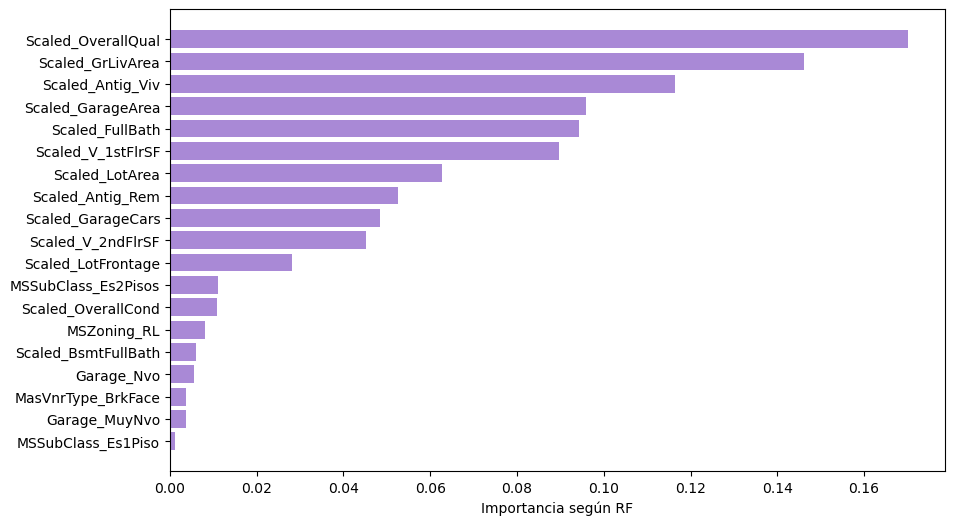

In [37]:
# Genero matriz de features y array de target
target = 'Scaled_SalePrice'
features = df_train_final.drop(columns=[target]).columns
X = df_train_final.drop(columns=[target]).values
y = df_train_final[target].values

# Crear el modelo de Random Forest
model = RandomForestRegressor(n_estimators = 150, 
                               random_state = 123,
                               max_depth = 5,
                               min_samples_leaf = 100,
                               max_features = 3) 

# Entrenar el modelo
model.fit(X, y)

# Obtener la importancia de las características
feature_importance = model.feature_importances_

# Crear un DataFrame para visualizar la importancia de las características
importance_df = pd.DataFrame({'Feature': features, 'Importance': feature_importance})
importance_df = importance_df.sort_values('Importance', ascending=False)
importance_df.sort_values(by = 'Importance', ascending = False)

# Grafico la importancia de cada variable
importance_df = importance_df.sort_values(by = 'Importance', ascending = False)
importance_df = importance_df.loc[importance_df['Importance'] > 0,]
plt.figure(figsize=(10, 6))  # Tamaño de la figura
plt.barh(importance_df['Feature'], 
         importance_df['Importance'],
         color = '#A989D6')
plt.xlabel('Importancia según RF')
plt.gca().invert_yaxis()  
plt.show() 


## Correlación entre variables

<Axes: >

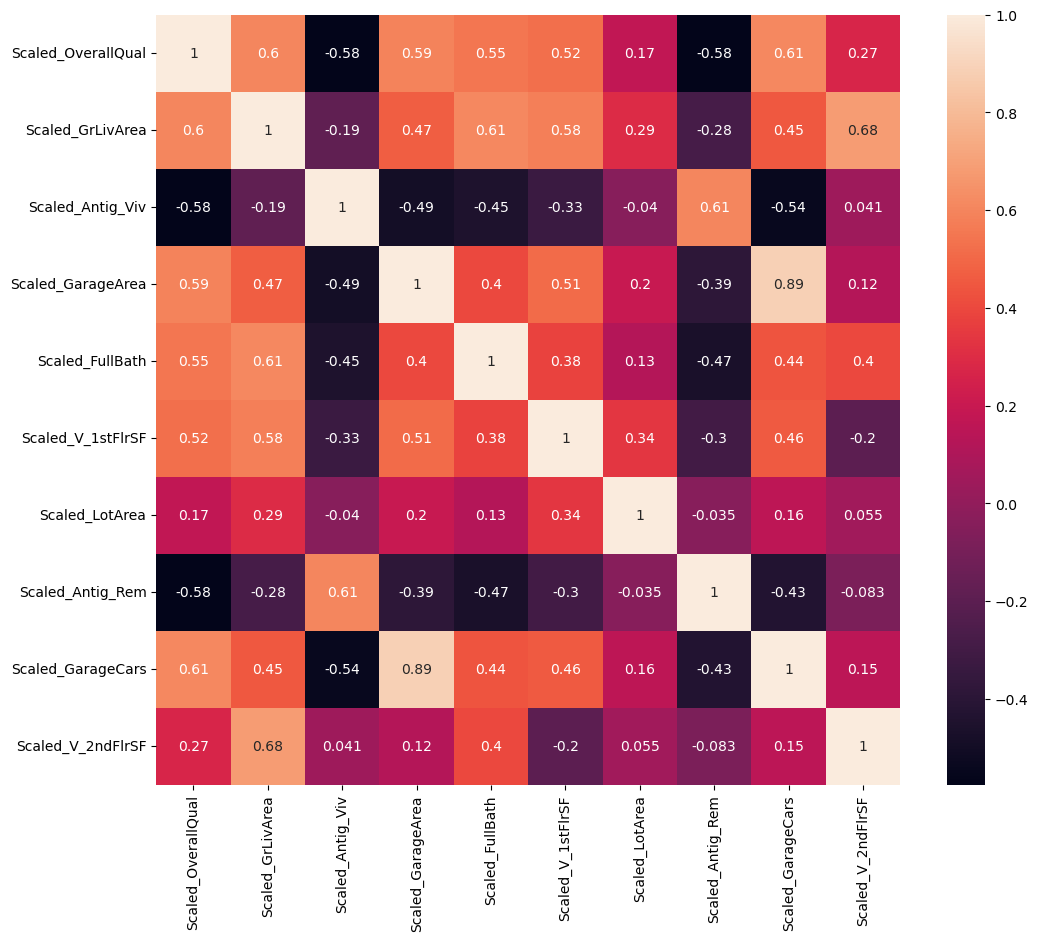

In [38]:
# Variables importantes 
features_imp = importance_df['Feature'].loc[importance_df['Importance'] > 0.04]

# Matriz de correlacion
matriz_corr = df_train_final[features_imp].corr()
fig, ax = plt.subplots(figsize=(12, 10))
sns.heatmap(matriz_corr, annot=True)

# Modelos 
Hoy vamos a comparar dos modelos: 
<br>
1. Regresión Lineal
2. Random Forest

## Modelo 1: Regresión Lineal


In [39]:
X_train = df_train_final[features_imp].values
y_train = df_train_final[target].values
X_test = df_test_final[features_imp].values
y_test = df_test_final[target].values

linear_model = LinearRegression()
linear_model.fit(X_train, y_train)

coeficientes = pd.DataFrame({'Features': features_imp,
                            'Coeficientes': linear_model.coef_})

# Print modelo
print('Intercepto', round(linear_model.intercept_,4))
print('')
print('Coeficientes')
coeficientes

Intercepto 0.0

Coeficientes


,Features,Coeficientes
3,Scaled_OverallQual,0.426912
0,Scaled_GrLivArea,0.208402
13,Scaled_Antig_Viv,-0.104149
1,Scaled_GarageArea,0.020189
12,Scaled_FullBath,-0.013183
7,Scaled_V_1stFlrSF,0.104301
5,Scaled_LotArea,0.090353
14,Scaled_Antig_Rem,-0.083441
2,Scaled_GarageCars,0.125361
8,Scaled_V_2ndFlrSF,0.018586


## Problema: 
Scaled_GarageArea y Scaled_GarageCars tienen un coeficiente de correlación de 0.89, y el coeficiente de Scaled_GarageArea es del signo contrario a lo que se espera. Por ello, vamos a sacar a esa variable del modelo. 

In [40]:
features_imp = features_imp[features_imp != 'Scaled_GarageArea']

X_train = df_train_final[features_imp].values
y_train = df_train_final[target].values
X_test = df_test_final[features_imp].values
y_test = df_test_final[target].values

linear_model = LinearRegression()
linear_model.fit(X_train, y_train)

coeficientes = pd.DataFrame({'Features': features_imp,
                            'Coeficientes': linear_model.coef_})

# Print modelo
print('Intercepto', round(linear_model.intercept_,4))
print('')
print('Coeficientes')
coeficientes

Intercepto 0.0

Coeficientes


,Features,Coeficientes
3,Scaled_OverallQual,0.427463
0,Scaled_GrLivArea,0.208416
13,Scaled_Antig_Viv,-0.104697
12,Scaled_FullBath,-0.014128
7,Scaled_V_1stFlrSF,0.107280
5,Scaled_LotArea,0.090676
14,Scaled_Antig_Rem,-0.083076
2,Scaled_GarageCars,0.141643
8,Scaled_V_2ndFlrSF,0.019403


In [41]:
# Predicciones 
y_pred_train = linear_model.predict(X_train)
y_pred_test = linear_model.predict(X_test)

# Convertimos en df la salida
df_train_predict = pd.DataFrame({'Scaled_SalePrice': y_train, 'Predict_RegLin': y_pred_train})
df_test_predict = pd.DataFrame({'Scaled_SalePrice': y_test, 'Predict_RegLin': y_pred_test})

df_test_predict.head()

,Scaled_SalePrice,Predict_RegLin
0,1.148221,0.644872
1,0.067992,0.071562
2,0.018739,0.462122
3,-0.416130,-0.433829
4,3.123949,1.611850


In [42]:
# Metricas 

# Train
mae_train_1 = metrics.mean_absolute_error(y_train, y_pred_train)
median_error_train_1 = metrics.median_absolute_error(y_train, y_pred_train)
max_error_train_1 = metrics.max_error(y_train, y_pred_train)
rmse_train_1 = np.sqrt(metrics.mean_squared_error(y_train, y_pred_train))
r2_train_1 = r2_score(y_train, y_pred_train)

# Test
mae_test_1 = metrics.mean_absolute_error(y_test, y_pred_test)
median_error_test_1 = metrics.median_absolute_error(y_test,y_pred_test)
max_error_test_1 = metrics.max_error(y_test,y_pred_test)
rmse_test_1 = np.sqrt(metrics.mean_squared_error(y_test, y_pred_test))
r2_test_1 = r2_score(y_test, y_pred_test)

In [43]:
print('')
print('TRAIN')
print('Mean Absolute Error: ', round(mae_train_1,4))
print('Median Absolute Error: ', round(median_error_train_1,4))
print('Max Error: ', round(max_error_train_1,4))
print('Error Cuadrático Medio: ', round(rmse_train_1,4))
print('R2: ', round(r2_train_1,4))
print('')
print('TEST')
print('Mean Absolute Error: ', round(mae_test_1,4))
print('Median Absolute Error: ', round(median_error_test_1,4))
print('Max Error: ', round(max_error_test_1,4))
print('Error Cuadrático Medio: ', round(rmse_test_1,4))
print('R2: ', round(r2_test_1,4))


TRAIN
Mean Absolute Error:  0.3154
Median Absolute Error:  0.2287
Max Error:  4.8436
Error Cuadrático Medio:  0.4792
R2:  0.7703

TEST
Mean Absolute Error:  0.3373
Median Absolute Error:  0.2163
Max Error:  4.2041
Error Cuadrático Medio:  0.5814
R2:  0.7626


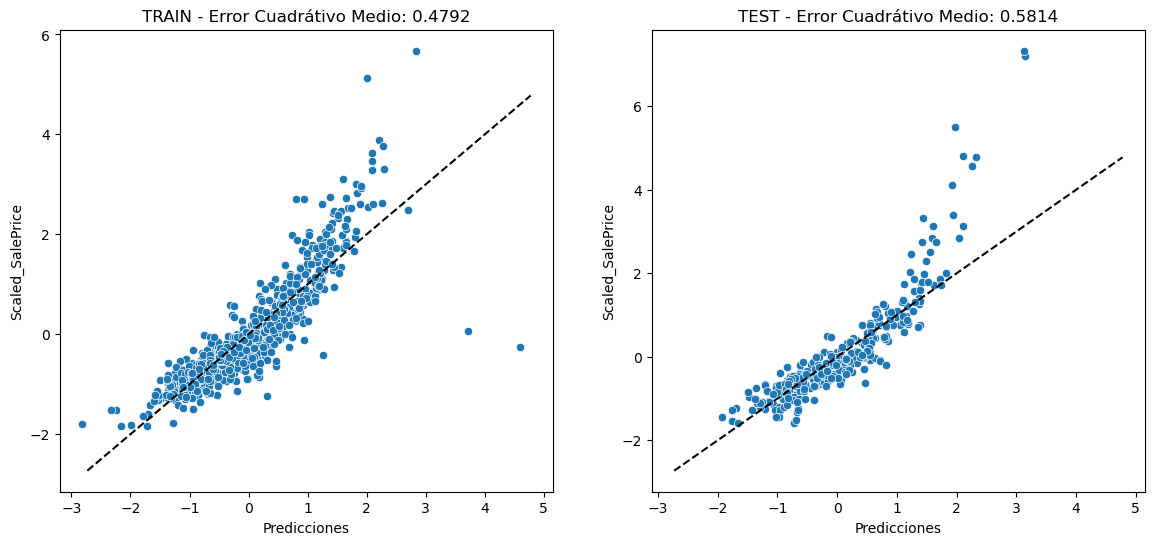

In [44]:
# Analisis Visual
minimo = df_train_predict['Predict_RegLin'].min()
maximo = df_train_predict['Predict_RegLin'].max()

fig, axs = plt.subplots(1, 2, figsize=(14, 6))

sns.scatterplot(data = df_train_predict,
                x = 'Predict_RegLin',
                y = 'Scaled_SalePrice',
                ax = axs[0])

axs[0].set_title('TRAIN - Error Cuadrátivo Medio: ' + str(round(rmse_train_1,4)))

linea_45_grados = np.linspace(minimo*0.97, maximo*1.04, 100)  

axs[0].plot(linea_45_grados, linea_45_grados, 
         color='black', linestyle='--', label='45°')  

axs[0].set_xlabel('Predicciones')

sns.scatterplot(data = df_test_predict,
                x = 'Predict_RegLin',
                y = 'Scaled_SalePrice',
                ax = axs[1])

axs[1].set_title('TEST - Error Cuadrátivo Medio: ' + str(round(rmse_test_1,4)))

linea_45_grados = np.linspace(minimo*0.97, maximo*1.04, 100)  

axs[1].plot(linea_45_grados, linea_45_grados, 
         color='black', linestyle='--', label='45°')  

axs[1].set_xlabel('Predicciones')

plt.show()

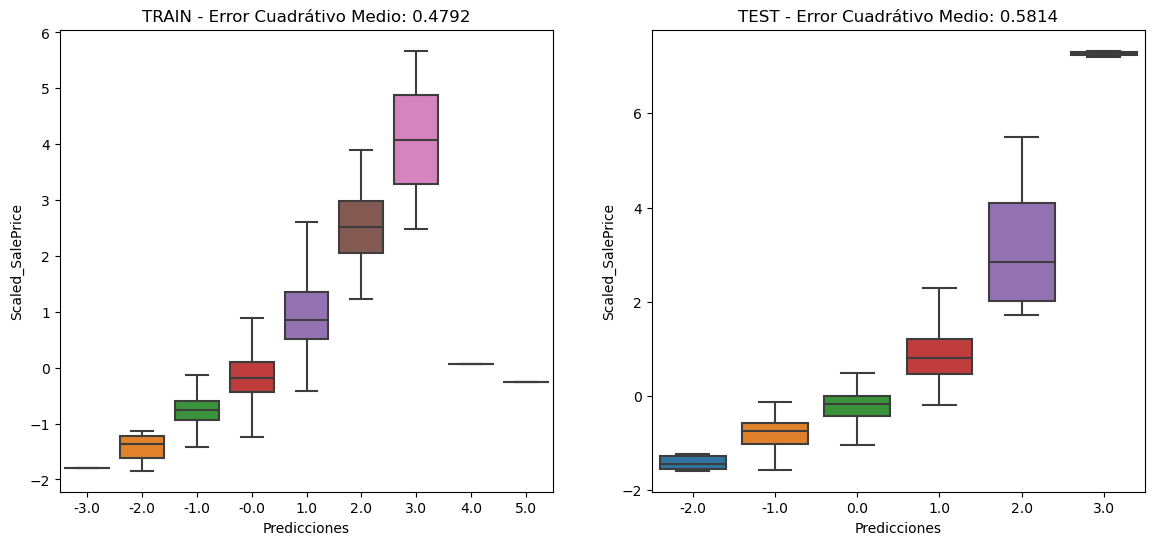

In [45]:
# Analisis Visual 2
df_train_predict['Predict_RegLin_bin'] = np.round(df_train_predict['Predict_RegLin'])
df_test_predict['Predict_RegLin_bin'] = np.round(df_test_predict['Predict_RegLin'])


fig, axs = plt.subplots(1, 2, figsize=(14, 6))

sns.boxplot(data = df_train_predict,
            x = 'Predict_RegLin_bin',
            y = 'Scaled_SalePrice', 
            showfliers = False,
            ax = axs[0])

axs[0].set_title('TRAIN - Error Cuadrátivo Medio: ' + str(round(rmse_train_1,4)))

axs[0].set_xlabel('Predicciones')

sns.boxplot(data = df_test_predict,
            x = 'Predict_RegLin_bin',
            y = 'Scaled_SalePrice', 
            showfliers = False,
            ax = axs[1])


axs[1].set_title('TEST - Error Cuadrátivo Medio: ' + str(round(rmse_test_1,4)))


axs[1].set_xlabel('Predicciones')

plt.show()

## Modelo 2: RandomForest

In [48]:
features_imp = features_imp[features_imp != 'Scaled_GarageArea']

X_train = df_train_final[features_imp].values
y_train = df_train_final[target].values
X_test = df_test_final[features_imp].values
y_test = df_test_final[target].values

rf_1 = RandomForestRegressor(n_estimators = 150, 
                               random_state = 123,
                               max_depth = 7,
                               min_samples_leaf = 100,
                               max_features = 3) 

# Entrenar el modelo
rf_1.fit(X_train, y_train)


RandomForestRegressor(max_depth=7, max_features=3, min_samples_leaf=100,
                      n_estimators=150, random_state=123)

In [49]:
# Predicciones 
y_pred_train = rf_1.predict(X_train)
y_pred_test = rf_1.predict(X_test)

# Convertimos en df la salida
df_train_predict['Predict_RandomForest'] = y_pred_train
df_test_predict['Predict_RandomForest'] = y_pred_test

df_test_predict.head()

,Scaled_SalePrice,Predict_RegLin,Predict_RegLin_bin,Predict_RandomForest
0,1.148221,0.644872,1.0,0.749140
1,0.067992,0.071562,0.0,-0.012138
2,0.018739,0.462122,0.0,0.429124
3,-0.416130,-0.433829,-0.0,-0.524611
4,3.123949,1.611850,2.0,1.042738


In [50]:
# Metricas 

# Train
mae_train_2 = metrics.mean_absolute_error(y_train, y_pred_train)
median_error_train_2 = metrics.median_absolute_error(y_train, y_pred_train)
max_error_train_2 = metrics.max_error(y_train, y_pred_train)
rmse_train_2 = np.sqrt(metrics.mean_squared_error(y_train, y_pred_train))
r2_train_2 = r2_score(y_train, y_pred_train)

# Test
mae_test_2 = metrics.mean_absolute_error(y_test, y_pred_test)
median_error_test_2 = metrics.median_absolute_error(y_test,y_pred_test)
max_error_test_2 = metrics.max_error(y_test,y_pred_test)
rmse_test_2 = np.sqrt(metrics.mean_squared_error(y_test, y_pred_test))
r2_test_2 = r2_score(y_test, y_pred_test)

In [ ]:
print('Modelo 2')
print('')
print('TRAIN')
print('Mean Absolute Error: ', round(mae_train_2,4))
print('Median Absolute Error: ', round(median_error_train_2,4))
print('Max Error: ', round(max_error_train_1,4))
print('Error Cuadrático Medio: ', round(rmse_train_1,4))
print('R2: ', round(r2_train_1,4))
print('')
print('TEST')
print('Mean Absolute Error: ', round(mae_test_1,4))
print('Median Absolute Error: ', round(median_error_test_1,4))
print('Max Error: ', round(max_error_test_1,4))
print('Error Cuadrático Medio: ', round(rmse_test_1,4))
print('R2: ', round(r2_test_1,4))